In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from utils import dump_dref
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind")

llfree = Path("frag/latest-ll")
buddy = Path("frag/latest-bu")


def save_dref(name: str, groupby: List[str], data: pd.DataFrame):
    out = {}
    data = data.dropna(axis=0).groupby(groupby).mean(numeric_only=True)
    for index, row in data.iterrows():
        out["/".join(map(str, row.name))] = row.values[0]
    with Path(f"out/{name}.dref").open("w+") as f:
        dump_dref(f, name, out)


In [2]:
import numpy as np
def parse_fragout(file: Path, iterations: int) -> pd.DataFrame:
    data = file.read_bytes()
    assert(len(data) % (iterations * 2) == 0)
    huge_pages = len(data) // iterations // 2
    out = np.zeros((iterations, huge_pages))
    for i in range(iterations):
        total = 0
        for hp in range(huge_pages):
            b = data[(i * huge_pages + hp) * 2:(i * huge_pages + hp) * 2 + 2]
            n = int.from_bytes(b, byteorder="little", signed=False)
            assert(n <= 512)
            total += n
            out[i,hp] = float(n)
        # print(huge_pages, total)
    return pd.DataFrame(out)

125.0
119.23003234863282


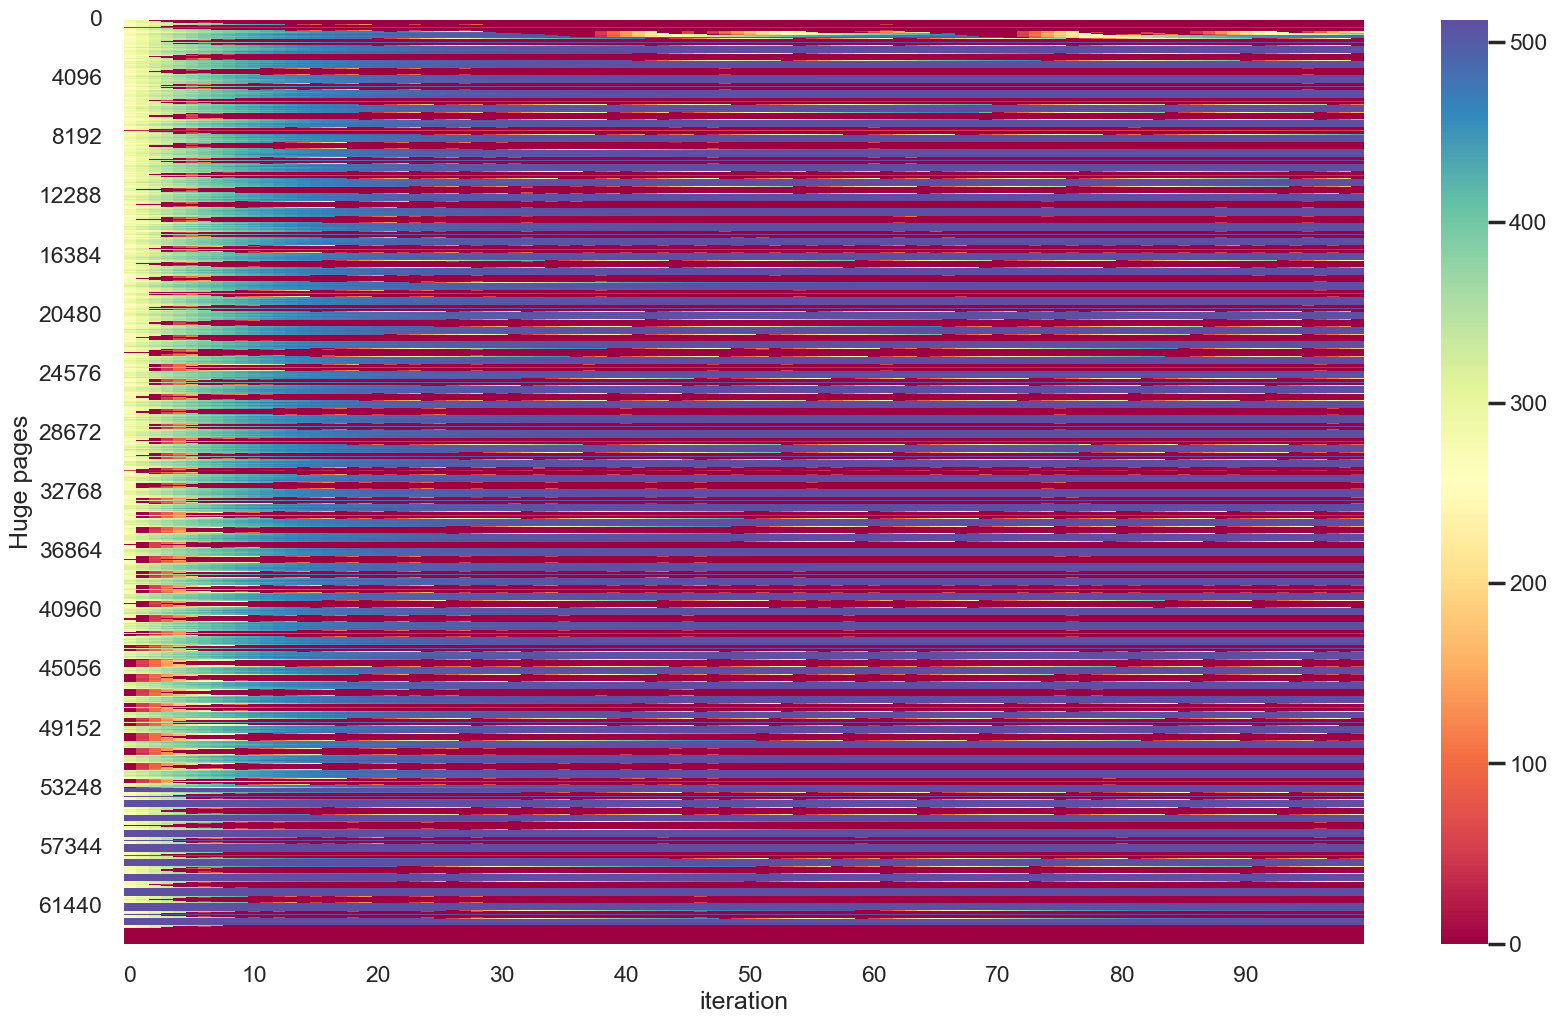

In [3]:
# Heatmap Array
fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(12)
fix.set_facecolor("white")

cmap = sns.color_palette("Spectral", as_cmap=True, n_colors=10)

data = parse_fragout(llfree / "fragout.bin", 100)
excerpt = data.T

plot = sns.heatmap(excerpt, ax=ax, cmap=cmap,
                   yticklabels=4*1024, xticklabels=10)
plot.set(ylabel="Huge pages")
plot.set(xlabel="iteration")

print(excerpt.size / 100 * 2 / 1024)
print(0.9 * 2 * 17364132 * 4096 / 1024 ** 3)


[Text(0.5, 84.91666666666664, 'iteration')]

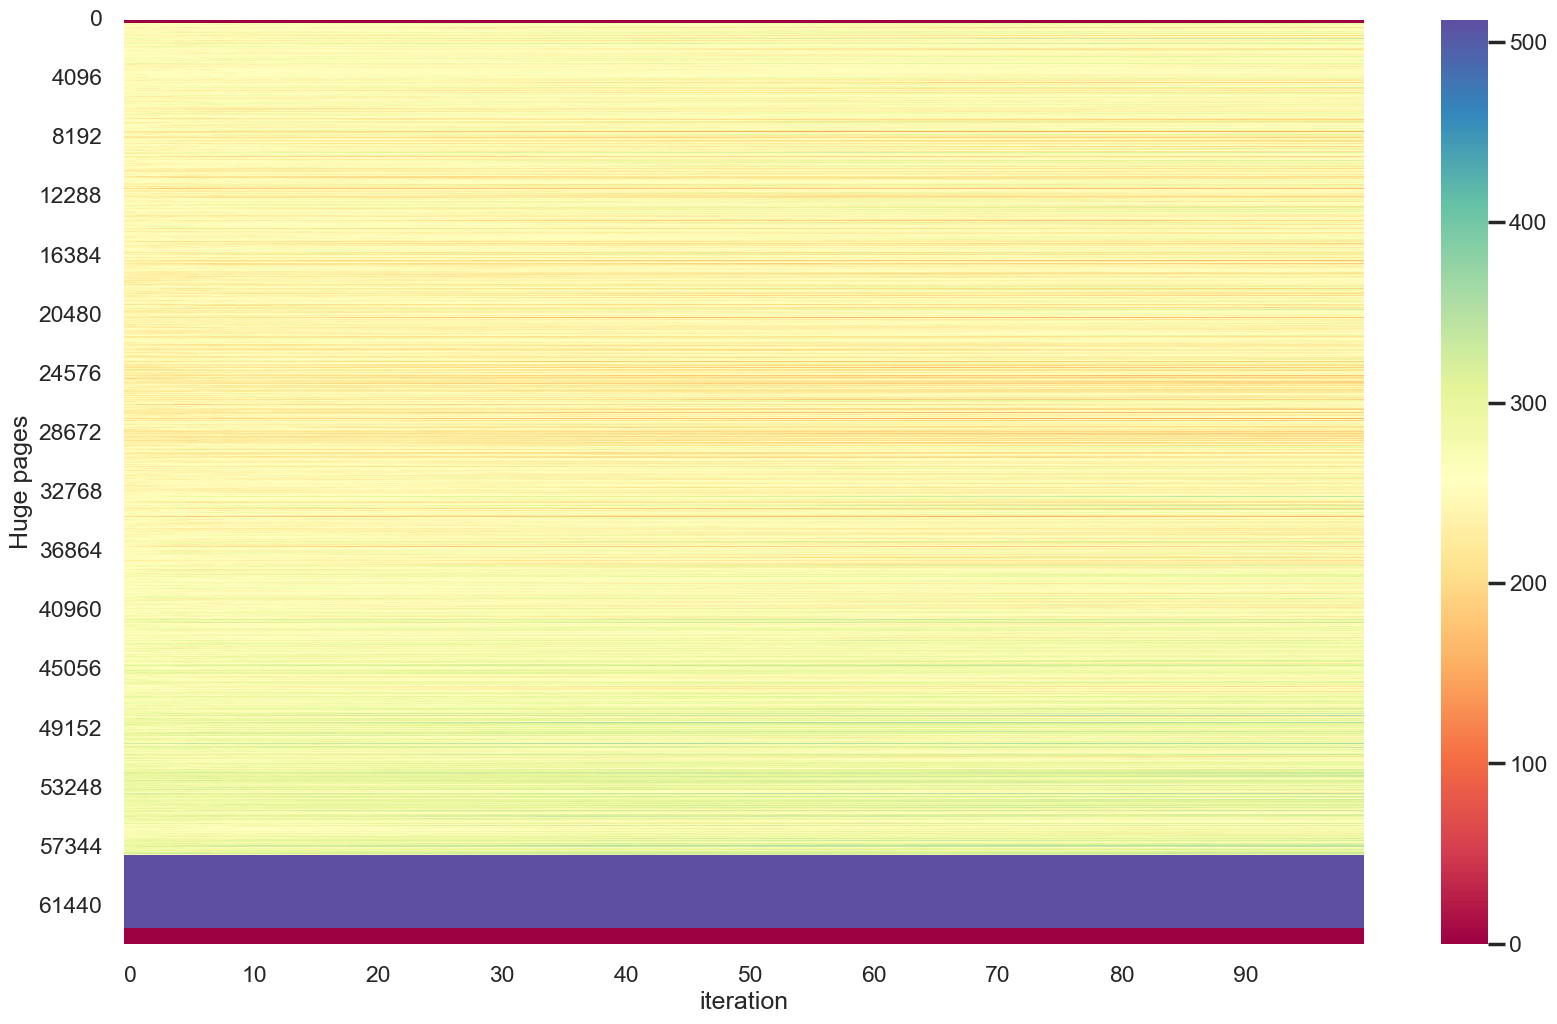

In [4]:
# Heatmap Array
fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(12)
fix.set_facecolor("white")

cmap = sns.color_palette("Spectral", as_cmap=True, n_colors=10)

data = parse_fragout(buddy / "fragout.bin", 100)
excerpt = data.T

plot = sns.heatmap(excerpt, ax=ax, cmap=cmap,
                   yticklabels=4*1024, xticklabels=10)
plot.set(ylabel="Huge pages")
plot.set(xlabel="iteration")


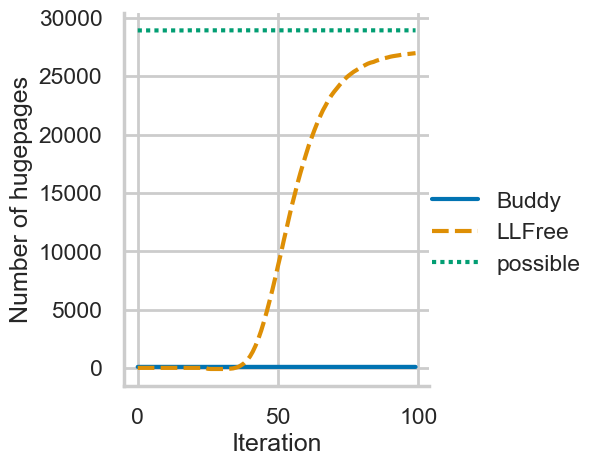

In [5]:
bdata = pd.read_csv(buddy / "out.csv")
bdata["possible"] = bdata["small"] / 512
bdata["Buddy"] = bdata["huge"]
bdata = bdata[["iter", "possible", "Buddy"]]

ndata = pd.read_csv(llfree / "out.csv")
ndata["LLFree"] = ndata["huge"]
ndata = ndata[["iter", "LLFree"]]

data = pd.concat([bdata, ndata])
data = data.melt(["iter"], value_vars=["Buddy", "LLFree", "possible"],
                 value_name="count", var_name="alloc")
data["count"] -= 5000  # subtract leftover
data["type"] = "moves"

plt = sns.relplot(data=data, kind="line", x="iter", y="count",
                  hue="alloc", style="alloc")
plt.set_titles("{col_name}")
# plt.set(ylim=(0, None))
plt.legend.set_title(None)
plt.set(xlabel="Iteration")
plt.set(ylabel="Number of hugepages")


In [6]:
def compaction_copies_per_iteration(data: pd.DataFrame):
    count = len(data.index)
    copies = np.zeros(count)
    # copies = [0] * count
    for n in range(count):
        print(n, "", end="")
        it = data.iloc[n].sort_values().reset_index(drop=True)
        left = 0
        right = len(it) - 1
        while left < right:
            d = min(512 - it[right], it[left])
            it[right] += d
            it[left] -= d
            copies[n] += d
            if it[right] == 512:
                right -= 1
            if it[left] == 0:
                left += 1
    print()
    return pd.DataFrame(copies)

buddy_data = parse_fragout(buddy / "fragout.bin", 100)
buddy_copies = compaction_copies_per_iteration(buddy_data)

llfree_data = parse_fragout(llfree / "fragout.bin", 100)
llfree_copies = compaction_copies_per_iteration(llfree_data)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


In [7]:
print(buddy_data.shape)

(100, 64000)


5024.0 33912.62109375


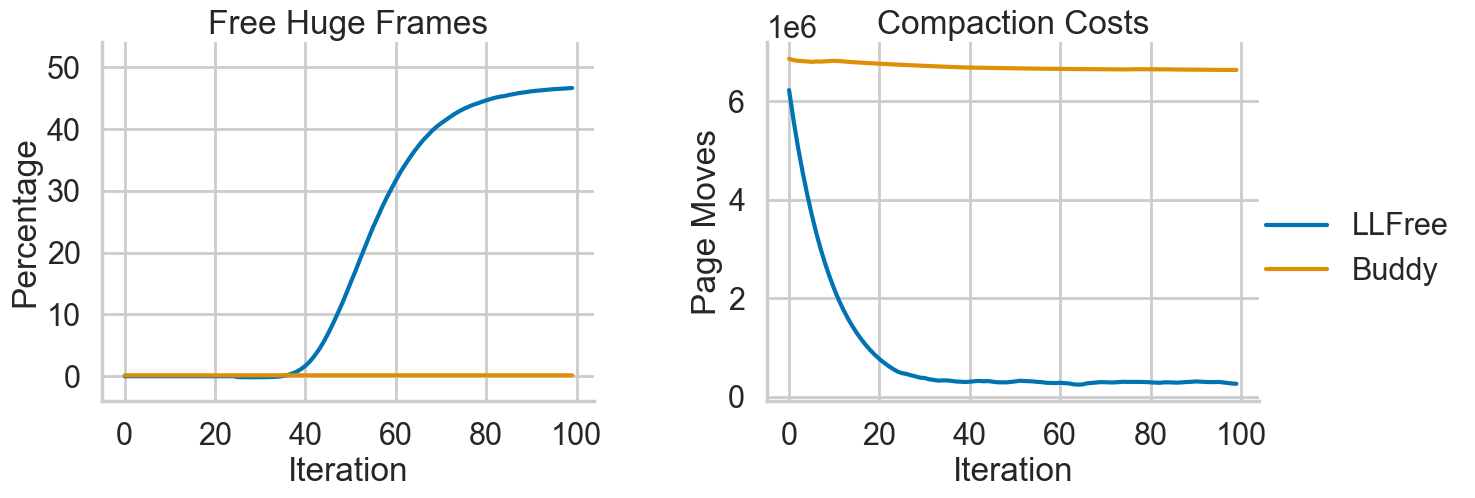

In [8]:
# Hugepages
bdata = pd.read_csv(buddy / "out.csv")
possible = bdata["small"][0] / 512
# bdata["Possible"] = bdata["small"] / 512
bdata["Buddy"] = bdata["huge"]
bdata = bdata[["iter", "Buddy"]]
ndata = pd.read_csv(llfree / "out.csv")
ndata["LLFree"] = ndata["huge"]
ndata = ndata[["iter", "LLFree"]]

huge = pd.concat([ndata, bdata])
huge = huge.melt(["iter"], value_vars=["LLFree", "Buddy"],
                 value_name="count", var_name="alloc")
initial = huge["count"][0]
print(initial, possible)
huge["count"] -= initial  # subtract leftover huge pages
huge["type"] = "Free Huge Frames"
huge["count"] /= (possible - initial) / 50 # normalize

# Moves
bdata = buddy_copies.copy()
bdata.columns = ["Buddy"]
bdata["iter"] = bdata.index
ldata = llfree_copies.copy()
ldata.columns = ["LLFree"]
ldata["iter"] = ldata.index

move = pd.concat([ldata, bdata])
move = move.melt(["iter"], value_vars=["LLFree", "Buddy"],
                 value_name="count", var_name="alloc")
move["type"] = "Compaction Costs"

# Combined
data = pd.concat([huge, move])
with sns.plotting_context("poster"):
    g = sns.FacetGrid(data, col="type", sharey=False, height=5.5, aspect=1.2)
    g.map_dataframe(sns.lineplot, x="iter", y="count", hue="alloc")
    g.set_titles(col_template="{col_name}")
    g.axes_dict["Free Huge Frames"].set(ylim=(-4, 54))
    g.set_xlabels("Iteration")
    g.set_ylabels("Percentage", clear_inner=False)
    g.set(xticks=[x * 20 for x in range(6)])
    g.set()
    g.add_legend()
    g.figure.subplots_adjust(wspace=0.35)
    g.axes_dict["Compaction Costs"].set(ylabel="Page Moves")
    g.axes_dict["Free Huge Frames"].set(yticks=[10 * x for x in range(6)])
    g.savefig("out/frag.pdf")

save_dref("frag", ["type", "alloc", "iter"], data)

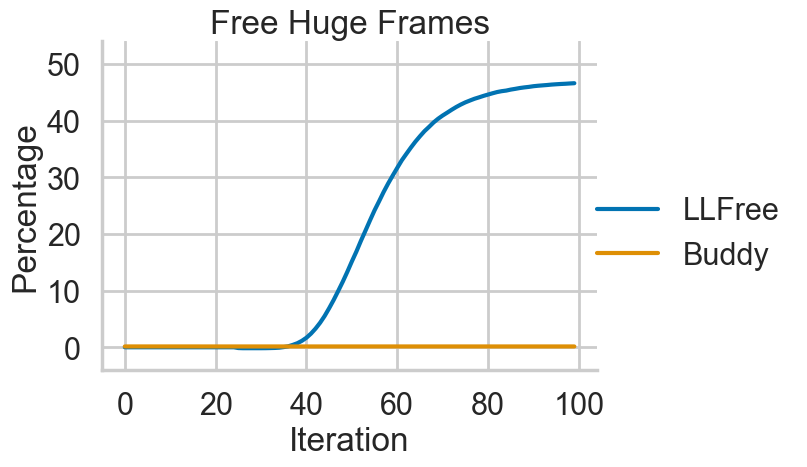

In [9]:
# Combined
with sns.plotting_context("poster"):
    g = sns.FacetGrid(data[data["type"] == "Free Huge Frames"], col="type", sharey=False, height=5.2, aspect=1.29)
    g.map_dataframe(sns.lineplot, x="iter", y="count", hue="alloc")
    g.set_titles(col_template="{col_name}")
    g.axes_dict["Free Huge Frames"].set(ylim=(-4, 54))
    g.set_xlabels("Iteration")
    g.set_ylabels("Percentage", clear_inner=False)
    g.set(xticks=[x * 20 for x in range(6)])
    g.set()
    g.add_legend()
    g.figure.subplots_adjust(wspace=0.35)
    g.axes_dict["Free Huge Frames"].set(yticks=[10 * x for x in range(6)])
    g.savefig("out/frag_huge.pdf")


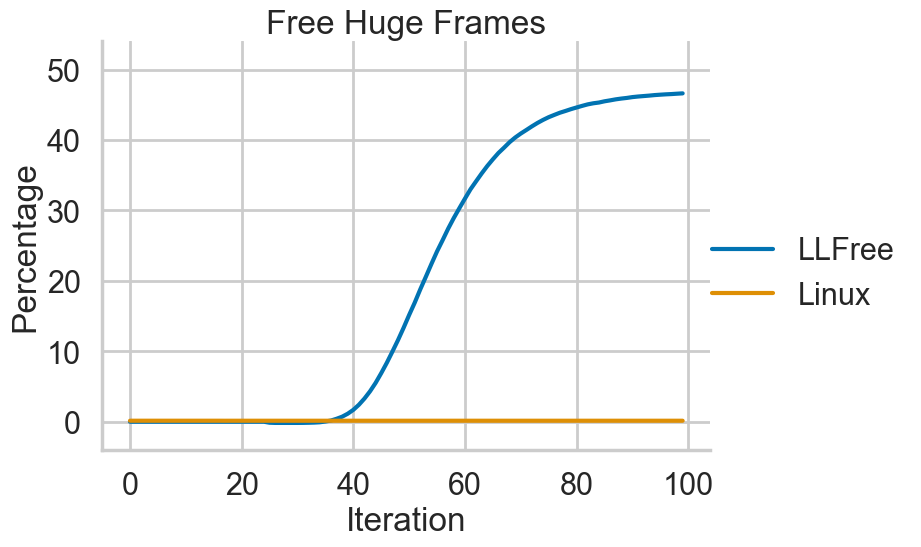

In [11]:
pgd = data[data["type"] == "Free Huge Frames"].copy()
pgd.replace({"alloc": "Buddy"}, "Linux", inplace=True)

with sns.plotting_context("poster"):
    g = sns.FacetGrid(pgd,
                      col="type", sharey=False, height=6, aspect=1.3)
    g.map_dataframe(sns.lineplot, x="iter", y="count", hue="alloc")
    g.set_titles(col_template="{col_name}")
    g.axes_dict["Free Huge Frames"].set(ylim=(-4, 54))
    g.set_xlabels("Iteration")
    g.set_ylabels("Percentage", clear_inner=False)
    g.set(xticks=[x * 20 for x in range(6)])
    g.set()
    g.add_legend()
    g.figure.subplots_adjust(wspace=0.35)
    g.axes_dict["Free Huge Frames"].set(yticks=[10 * x for x in range(6)])
    g.savefig("talk/frag.pdf")
